# Final Project – Jithendra Seneviratne  

This project uses both the [Beer Recommender Data](https://snap.stanford.edu/data/web-BeerAdvocate.html) as well as the [Jester dataset](http://eigentaste.berkeley.edu/about.html) to run various collaborative filtering models and evaluate their performance. We will use an AWS EC2 instance to gain the processing power needed to manipulate very large sparse matrices.

Let's also manufacture a user who likes stouts to see if the model can actually predict the user's taste!

We already know that the optimal number of weights for the Beer Advocate data is ten (see previous project [here](https://github.com/jitsen-design/CUNY_Recommender_Project_Samples/blob/master/Assignment_5/Assignment_5.ipynb)). As an additional exercise, we'll use Apache Spark to evaluate the optimal number of training weights for the following datasets.

* Book Review Data [(From a previous exercise)](https://www.kaggle.com/philippsp/book-recommender-collaborative-filtering-shiny/data)
* Jester Dataset (Used in this exercise)

[See Spark work here](https://github.com/jitsen-design/CUNY_Recommender_Project_Samples/blob/master/Final_Project/final_spark.ipynb)

### Objectives:
*	Use cloud computing for efficiency 
*   Check sparsity of both datasets
*	Use different models in the Surprise package to decide ideal algorithm (using RMSE)
*	Compare model performance with levels of spartsity
*   Fabricate user (myself) and see predictions on my ratings (using different models)
*	Look at performance metrics other than RMSE by tuning the minimum number of ratings (manoipulating sparsity)
*	Additional exercise: Look at ideal number of weights for different datasets using Apache Spark


### Metrics Other Than RMSE

We'll explore ideas such as Personalization and Coverage below. Documentation for the [Recmetrics package](https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093) suggest that maximizing personalization and coverage is desirable. 

#### Coverage
This is the % of recommendations the model can make on the testset. 

#### Personalization
This is the level of personalized recommendations the algorithm spits back. This might be of particular value to users, as unique and accurate recommendations are better than simply accuate recommendations.

#### Hyper-Parameter
We'll use the minimum number of ratings the user has provided as parameter and retrieve RMSE, Coverage and Personalization for different filtered models

### Import Modules and Libraries for Analysis

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
import zipfile
from math import sqrt
import zipfile
import urllib
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
import surprise
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
import matplotlib.pyplot as plt
pd.set_option("max_columns",200)
import pickle
import recmetrics
from recmetrics import coverage, personalization

### Import Datasets for analysis

We'll be analyzing both the Jester Dataset as well as the Beer Reviews Dataset

In [4]:
jester_ratings = pd.read_csv('data/jester_ratings.csv',
                             nrows=200000)

beer_ratings =   pd.read_csv("data/beer_reviews.csv",
                             nrows=200000
                            )

### Distribution of Review Counts

We'll begin by checking the counts of reviews by 

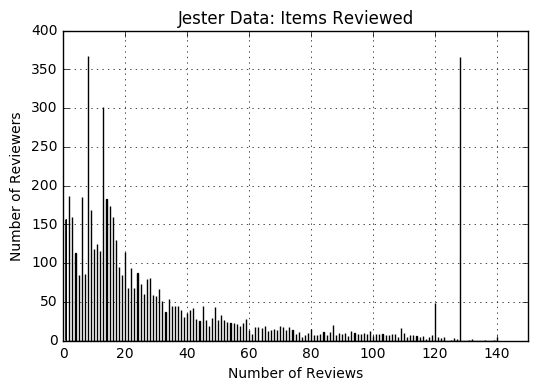

In [5]:
jester_ratings.groupby('user').agg({'item':'count'}).hist(bins=5000);
plt.xlim(0,150);
plt.title('Jester Data: Items Reviewed')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Reviewers')
plt.show();

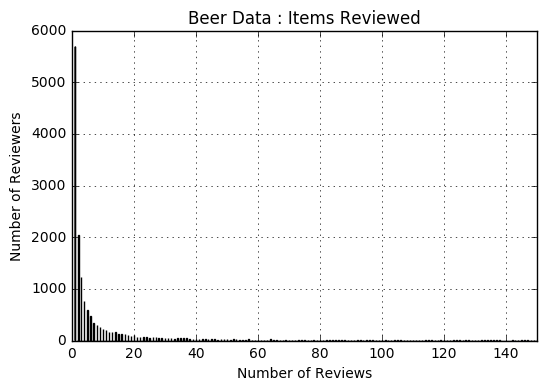

In [6]:
beer_ratings.groupby('review_profilename').agg({'beer_beerid':'count'}).hist(bins=5000);
plt.xlim(0,150);
plt.title('Beer Data : Items Reviewed')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Reviewers')
plt.show();

We can see that the Beer data is more spase than the Jester dataset given that many more users have reviewed a higher number of jokes

### Transform Ratings
Transfomr ratings to be on scale from 0 to 5 for comparison

In [5]:
jester_ratings['rating'] = MinMaxScaler((0, 5)).fit_transform(jester_ratings[['rating']])

### Create Readable Datasets

Create datasets readable by Surprise Package from Jester and Beer Advocate Datasets

In [6]:
reader = surprise.Reader(rating_scale=(0, 5))
jester_surprise = surprise.Dataset.load_from_df(jester_ratings[['user',
                                                                'item',
                                                                'rating']]
                                                                , reader)
beer_surprise = surprise.Dataset.load_from_df(beer_ratings[['reviewer_id',
                                                            'beer_beerid',
                                                            'review_overall']]
                                                            , reader)

In [7]:
def surprise_benchmarking(data):
    benchmark = []
    # Iterate over all algorithms
    for algorithm in [surprise.SVD(), 
                      surprise.SVDpp(),  
                      surprise.BaselineOnly()]:
        # Perform cross validation
        results = surprise.model_selection.cross_validate(algo=algorithm, 
                                                          data=data, 
                                                          measures=['RMSE'],
                                                          cv=2,
                                                          return_train_measures=True,
                                                          verbose=False)

        # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)
    return benchmark

In [8]:
jester_benchmark = surprise_benchmarking(data=jester_surprise)

Estimating biases using als...
Estimating biases using als...


### Model Ranking for Jester Dataset

In [188]:
pd.DataFrame(jester_benchmark)

,fit_time,test_rmse,test_time,train_rmse,Algorithm
0,6.715074,1.182857,1.051020,0.625298,SVD
1,71.953347,1.184519,6.023758,0.769897,SVDpp
2,0.136011,1.195712,0.945965,1.162122,BaselineOnly


In [10]:
beer_benchmark = surprise_benchmarking(data=beer_surprise)

Estimating biases using als...
Estimating biases using als...


### Model Ranking for Beer Dataset

In [190]:
pd.DataFrame(beer_benchmark)

,fit_time,test_rmse,test_time,train_rmse,Algorithm
0,6.943989,0.609845,1.090457,0.482402,SVD
1,94.817396,0.604484,7.489737,0.518261,SVDpp
2,0.186859,0.603671,0.932658,0.574197,BaselineOnly


### Model Performance Chart

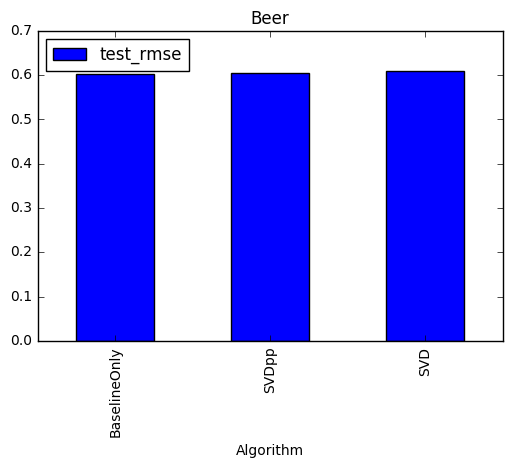

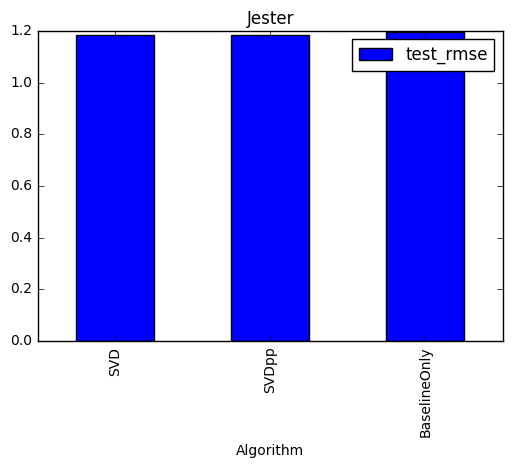

In [193]:
plt.Figure(figsize=(40,20))
pd.DataFrame(beer_benchmark).sort_values(by='test_rmse').set_index('Algorithm').plot(y='test_rmse',
                                                         kind='bar',
                                                         title='Beer');
pd.DataFrame(jester_benchmark).sort_values(by='test_rmse').set_index('Algorithm').plot(y='test_rmse',
                                                           kind='bar',
                                                           title='Jester');
plt.show();

We know from our previous work that the baseline predictor performs better than SVDpp when data is less sparse. However, in this case, the data seems to be performing worst on the Jester dataset (the less sparse dataset!). We may have clues in the variance of the two datasets.

### Standard Deviation for Jester Ratings

In [102]:
jester_ratings['rating'].round().std()

1.5025184135011

### Standard Deviation for Beer Ratings

In [103]:
beer_ratings['review_overall'].std()

0.6931140783664599

### Distribution of Review Counts for Beer Data

In [65]:
beer_ratings.groupby('reviewer_id')['beer_beerid'].count().value_counts(1).sort_index(ascending=True)[:10]

1     0.367031
2     0.131387
3     0.079969
4     0.049609
5     0.038434
6     0.030037
7     0.021833
8     0.019572
9     0.016343
10    0.014986
Name: beer_beerid, dtype: float64

### Distribution of Review Counts for Jester Data

In [77]:
jester_ratings.groupby('user')['item'].count().value_counts(1).sort_index(ascending=True)[:10]

1     0.026580
2     0.031692
3     0.027091
4     0.019254
5     0.014312
6     0.031522
7     0.014653
8     0.062532
9     0.028625
10    0.020106
Name: item, dtype: float64

### Both Distributions Plotted

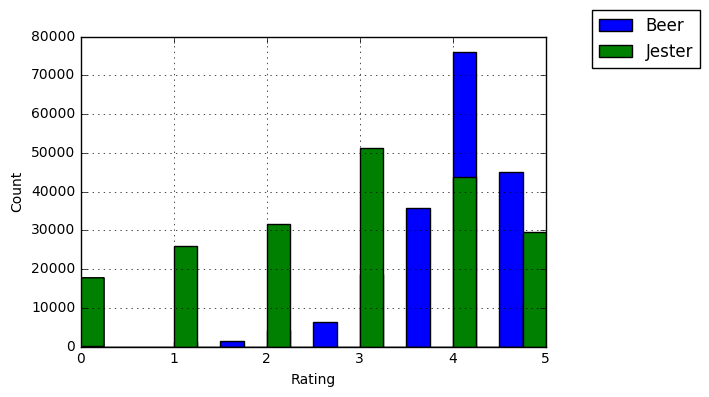

In [111]:
beer_ratings['review_overall'].hist(bins=20, label='Beer');
jester_ratings['rating'].round().hist(bins=20, label='Jester');
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(loc=[1.1,0.9]);
plt.show();

Perhaps the reason that the Baseline predictor is not doing well on the less sparse data (Jester data) was because of the highly varied ratings!

### Create Dataframe with My Ratings

Now we come the the point where we'd try and predict my personal preference. I like stouts but don't like pale ales, so let's see how the algorithm does on my preferences!

In [7]:
my_ratings = pd.DataFrame({'beer_beerid':[74998, 47570, 7371, 25414, 1607, 19946, 2984, 436,16302,43687,65636,34799],
                           'beer_name': ["Sparky's Chocolate Milk Stout",
                                         "CaCow! Chocolate Milk Stout",
                                         "Castle Milk Stout",
                                         "Caldera Pale Ale",
                                         "Sierra Nevada India Pale Ale",
                                         "Pacific Pale Ale (Pacific Summer Ale)",
                                         "Hale's Pale Ale",
                                         "Amstel Light",
                                         "Dragons Milk Stout",
                                         "Creme Brulee (Imperial Milk Stout)",
                                         "Amarillo Single Hop Pale Ale",
                                         "San Francisco Pale Ale"],
                           'reviewer_id':[99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999],
                           'review_overall':[5, 4.5, 4.5, 1.5, 1.0, 1.5, 1.5, 1.0, 4.5, 4.5, 1.0, 1.0]})

In [6]:
my_ratings

,beer_beerid,beer_name,reviewer_id,review_overall
0,74998,Sparky's Chocolate Milk Stout,99999,5.0
1,47570,CaCow! Chocolate Milk Stout,99999,4.5
2,7371,Castle Milk Stout,99999,4.5
3,16302,Dragons Milk Stout,99999,4.5
4,43687,Creme Brulee (Imperial Milk Stout),99999,4.5
5,15228,Chocolate Milk Stout,99999,5.0
6,72162,Mother's Milk Stout,99999,4.5


### Recreate Original Dataset to Include My Preferences

In [113]:
beer_ratings =   pd.read_csv("data/beer_reviews.csv",
                             nrows=200000)
beer_ratings = pd.concat([beer_ratings[['beer_beerid',
                                        'beer_name',
                                        'reviewer_id',
                                        'review_overall']],
                          my_ratings])

/home/jitsen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [114]:
reader = surprise.Reader(rating_scale=(0, 5))
beer_surprise = surprise.Dataset.load_from_df(beer_ratings[['reviewer_id',
                                                            'beer_beerid',
                                                            'review_overall']]
                                                            , reader)

### Create Mapping Dictionary for Ids to Names

In [12]:
beer_map_dict = {}
for i,j in beer_ratings.drop_duplicates(subset=['beer_beerid']).iterrows():
    beer_map_dict[j['beer_beerid']] = j['beer_name']

### Create Function to Map Beer Names to IDs

In [116]:
def get_top_n(predictions_df, 
              user_id,
              map_dict,
              n=10):
    subset=predictions_df[predictions_df['uid']==user_id].sort_values(by='est',
                                                                     ascending=False)[:10]
    subset['original_title']=subset['iid'].map(map_dict)

    return subset

In [118]:
beer_trainset, beer_testset = surprise.model_selection.train_test_split(beer_surprise, test_size=.3)
beer_model = surprise.SVDpp(n_epochs = 15,
                            n_factors = 10,
                            lr_all = 0.005,
                            reg_all = 0.4)
beer_model.fit(beer_trainset)
beer_predictions = beer_model.test(beer_testset)
beer_pred_df = pd.DataFrame(beer_predictions).sort_values(by=['uid', 
                                                              'iid'])

### Get Predictions

In [120]:
get_top_n(beer_pred_df, 
          user_id=99999,
          map_dict=beer_map_dict,
          n=10)

,uid,iid,r_ui,est,details,original_title
45000,99999,25414,1.5,3.444230,{'was_impossible': False},Caldera Pale Ale
12351,99999,16302,4.5,3.290556,{'was_impossible': False},Dragons Milk Stout
34169,99999,43687,4.5,3.096573,{'was_impossible': False},Creme Brulee (Imperial Milk Stout)
35355,99999,436,1.0,2.600018,{'was_impossible': False},Amstel Light


The predictions aren't great, and we seem to have many middle of the road predictions. Perhaps the fact that we've rated ales even though we don't like them is telling the implcit model that we like them. Therefore, let's try our test using the baseline model only

### Run Data on Baseline Model

In [117]:
beer_model = surprise.BaselineOnly({'method': 'als',
                                    'n_epochs': 15})
beer_model.fit(beer_trainset)
beer_predictions = beer_model.test(beer_testset)
beer_pred_df = pd.DataFrame(beer_predictions).sort_values(by=['uid', 
                                                              'iid']) 

get_top_n(beer_pred_df, 
          user_id=99999,
          map_dict=beer_map_dict,
          n=10)

Estimating biases using als...


,uid,iid,r_ui,est,details,original_title
45000,99999,25414,1.5,3.591267,{'was_impossible': False},Caldera Pale Ale
12351,99999,16302,4.5,3.435732,{'was_impossible': False},Dragons Milk Stout
34169,99999,43687,4.5,3.081663,{'was_impossible': False},Creme Brulee (Imperial Milk Stout)
35355,99999,436,1.0,2.373182,{'was_impossible': False},Amstel Light


Unfortunately, the Baseline model seems to have done the same. Curiously, the rankings seem the same as well. Could it be that similar users seem to enjoy Caldera Pale Ale along wth stouts?? Let's try rating only stouts to see if that helps the problem.

### Rate Only Stouts

The hope here is that rating just the stouts will yield better results with SVDpp, since SVDpp accounts for implicit ratings.

In [5]:
my_ratings = pd.DataFrame({'beer_beerid':[74998, 47570, 7371,16302,43687,15228,72162],
                           'beer_name': ["Sparky's Chocolate Milk Stout",
                                         "CaCow! Chocolate Milk Stout",
                                         "Castle Milk Stout",
                                         "Dragons Milk Stout",
                                         "Creme Brulee (Imperial Milk Stout)",
                                         "Chocolate Milk Stout",
                                         "Mother's Milk Stout"
                                         ],
                           'reviewer_id':[99999,99999,99999,99999,99999,99999,99999],
                           'review_overall':[5, 4.5, 4.5, 4.5, 4.5, 5.0, 4.5]})

### (Previous Process)

In [18]:
beer_ratings =   pd.read_csv("data/beer_reviews.csv",
                             nrows=200000)

beer_ratings = pd.concat([beer_ratings[['beer_beerid',
                                        'beer_name',
                                        'reviewer_id',
                                        'review_overall']],
                          my_ratings])
beer_surprise = surprise.Dataset.load_from_df(beer_ratings[['reviewer_id',
                                                            'beer_beerid',
                                                            'review_overall']]
                                                            , reader)

beer_map_dict = {}
for i,j in beer_ratings.drop_duplicates(subset=['beer_beerid']).iterrows():
    beer_map_dict[j['beer_beerid']] = j['beer_name']

beer_trainset, beer_testset = surprise.model_selection.train_test_split(beer_surprise, test_size=.3)
beer_model = surprise.SVDpp(n_epochs = 15,
                            n_factors = 10,
                            lr_all = 0.005,
                            reg_all = 0.4)
beer_model.fit(beer_trainset)
beer_predictions = beer_model.test(beer_testset)
beer_pred_df = pd.DataFrame(beer_predictions).sort_values(by=['uid', 
                                                              'iid'])

In [125]:
get_top_n(beer_pred_df, 
          user_id=99999,
          map_dict=beer_map_dict,
          n=10)

,uid,iid,r_ui,est,details,original_title
34407,99999,16302,4.5,4.110178,{'was_impossible': False},Dragons Milk Stout
29204,99999,15228,5.0,4.063977,{'was_impossible': False},Chocolate Milk Stout
54275,99999,43687,4.5,3.787468,{'was_impossible': False},Creme Brulee (Imperial Milk Stout)


Okay, the model seems top have done better! Let's test our result on a pale ale to see the predicttion!

### Get Prediction from New Model

Let's predict the rating for a pale ale using the new model

In [127]:
beer_model.predict(uid=99999, 
                   iid=19946)

Prediction(uid=99999, iid=19946, r_ui=None, est=4.158007412373692, details={'was_impossible': False})

Unfortunately, the model thinks we tend to rate pale ales fairly highly. Perhaps we are correct in assuming other users who like stouts also tend to like pale ales.

### Performance Metrics Other Than RMSE

Let's look at RMSE in cojunction with Coverage and Personalization

In [21]:
def coverage_personalization(data, threshold):
    
    data_temp=data[data['reviewer_id'].isin((data['reviewer_id'].value_counts()>threshold).index)]
    reader = surprise.Reader(rating_scale=(0, 5))
    data_surprise_temp = surprise.Dataset.load_from_df(data_temp[['reviewer_id', 
                                                                  'beer_beerid', 
                                                                  'review_overall']], reader)

    # sample random trainset and testset
    # test set is made of 25% of the ratings.
    trainset_temp, testset_temp = train_test_split(data_surprise_temp, test_size=.25)

    # We'll use the famous SVD algorithm.
    algo_temp = beer_model = surprise.BaselineOnly({'method': 'als',
                                                    'n_epochs': 15})

    # Train the algorithm on the trainset, and predict ratings for the testset
    algo_temp.fit(trainset_temp)
    predictions_temp = algo_temp.test(testset_temp)

    # Then compute RMSE
    rmse = accuracy.rmse(predictions_temp)
    print('Step 1 Done!')
    
    predictions_temp_df = pd.DataFrame(predictions_temp, 
                                       columns=['reviewer_id', 
                                                'beer_beerid',
                                                'review_overall', 
                                                'predictions', 
                                                'details'])
    del predictions_temp
    
    # Get names of books
    predictions_temp_df['beer_name'] = predictions_temp_df['beer_beerid'].map(beer_map_dict)

    pred_matrix = predictions_temp_df.sort_values(by=['reviewer_id',
                               'predictions']).groupby('beer_beerid')['beer_name'].apply(lambda x: list(x))
    
    del predictions_temp_df
    print('Step 2 Done!')
    
    # Get level of personalization
    personalization = recmetrics.personalization(pred_matrix.sample(1000).tolist())
    print('Step 3 Done!')
    
    # Get coverage
    coverage = recmetrics.coverage(pred_matrix.tolist(),trainset_temp.all_users())
    print('Step 4 Done!')
    return [rmse,personalization,coverage]

### Run Model While Tuning HyperParameter

In [22]:
performance_list = []

for i in [0,1,5,10,15]:
    performance_list.append([i]+coverage_personalization(beer_ratings,i))

Estimating biases using als...
RMSE: 0.5982
Step 1 Done!
Step 2 Done!
Step 3 Done!
Step 4 Done!
Estimating biases using als...
RMSE: 0.5962
Step 1 Done!
Step 2 Done!
Step 3 Done!
Step 4 Done!
Estimating biases using als...
RMSE: 0.5958
Step 1 Done!
Step 2 Done!
Step 3 Done!
Step 4 Done!
Estimating biases using als...
RMSE: 0.5976
Step 1 Done!
Step 2 Done!
Step 3 Done!
Step 4 Done!
Estimating biases using als...
RMSE: 0.5989
Step 1 Done!
Step 2 Done!
Step 3 Done!
Step 4 Done!


### Look at Performance Metrics Visually

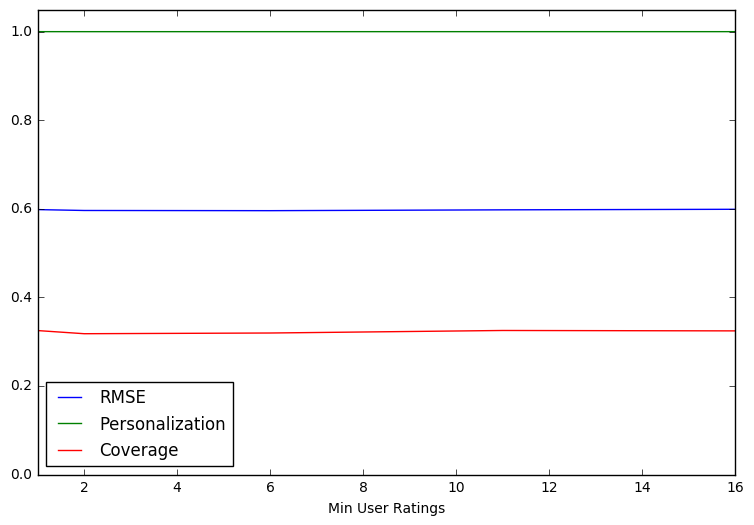

In [23]:
performance_df = pd.DataFrame(performance_list,
             columns=['Min User Ratings',
                      'RMSE',
                      'Personalization',
                      'Coverage']).set_index('Min User Ratings')

# Turn Coverage into Fraction
performance_df['Coverage'] = performance_df['Coverage']/100
performance_df.index = performance_df.index+1

plt.rcParams["figure.figsize"] = (9,6);
performance_df.plot();
plt.ylim(0,1.05);
plt.show();

### Performance Metric Values

In [24]:
performance_df

,RMSE,Personalization,Coverage
Min User Ratings,,,
1,0.598168,0.999982,0.3250
2,0.596177,0.999952,0.3179
6,0.595751,0.999954,0.3195
11,0.597612,0.999978,0.3252
16,0.598868,0.999964,0.3243


We can see that the RMSE is lowest when we have between 5 and ten ratings. Less than that or more than that probably means too much sparsity. However, it interesting to note that when coverage is least, the RMSE is also the lowest!

## Summary

Sparsity affects data but so does variance of ratings. Since our Beer data had low variance, the RMSE was naturally lower. Also, all models seemed to be influenced by the fact that (apparently) those who liked pale ales also enjoyed stouts! Finally we can tell that a fewer number of weights (10) is better than a higher number (20) [See Spark Notebook](https://github.com/jitsen-design/CUNY_Recommender_Project_Samples/blob/master/Final_Project/final_spark.ipynb).